# Random Forest Models

In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from skimage import color
from sklearn.model_selection import RandomizedSearchCV
import time

## Load Data

In [14]:
images_train = np.load("../data/images/images_train.npy")
images_test = np.load("../data/images/images_test.npy")
num_samples_train = images_train.shape[0]
num_samples_test = images_test.shape[0]

images_train = images_train.reshape(num_samples_train, -1)
images_test = images_test.reshape(num_samples_test, -1)

hog_train = np.load("../data/hog/hog_train.npy").reshape(num_samples_train, -1)
hog_train = hog_train * 255
hog_test = np.load("../data/hog/hog_test.npy").reshape(num_samples_test, -1)
hog_test = hog_test * 255

canny_edges_train  = np.load("../data/canny_edges/canny_edges_train.npy").reshape(num_samples_train, -1)
canny_edges_test  = np.load("../data/canny_edges/canny_edges_test.npy").reshape(num_samples_test, -1)

contours_train = np.load("../data/contours/contours_train.npy").reshape(num_samples_train, -1)
contours_test = np.load("../data/contours/contours_test.npy").reshape(num_samples_test, -1)

imagenet_train = np.load("../data/vgg19/vgg19_train.npy").reshape(num_samples_train, -1)
imagenet_test = np.load("../data/vgg19/vgg19_test.npy").reshape(num_samples_test, -1)

#pca_train = np.load("../data/pca/pca_train.npy")
#pca_test = np.load("../data/pca/pca_test.npy")

y_train = np.load("../data/images/label_ids_train.npy")
y_test = np.load("../data/images/label_ids_test.npy")

train_indices = np.random.permutation(num_samples_train)
images_train = images_train[train_indices]
hog_train = hog_train[train_indices]
canny_edges_train = canny_edges_train[train_indices]
contours_train = contours_train[train_indices]
imagenet_train = imagenet_train[train_indices]
#pca_train = pca_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.random.permutation(num_samples_test)
images_test = images_test[test_indices]
hog_test = hog_test[test_indices]
canny_edges_test = canny_edges_test[test_indices]
contours_test = contours_test[test_indices]
imagenet_test = imagenet_test[test_indices]
#pca_test = pca_test[test_indices]
y_test = y_test[test_indices]


In [15]:
labels_train = np.load("../data/images/labels_train.npy")
class_lookup = list(set(zip(np.load("../data/images/label_ids_train.npy"), labels_train)))
class_lookup = {id_value: class_value for id_value, class_value in class_lookup}
class_lookup
sorted_class_lookup = {k: class_lookup[k] for k in sorted(class_lookup)}
label_names = list(sorted_class_lookup.values())

In [16]:
def show_confusion_matrix(confusion_matrix):
  ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                  xticklabels=label_names, yticklabels=label_names, cbar=False)

  # Add axis labels.
  ax.set(xlabel='Predicted Label', ylabel='True Label')
  plt.show()

In [17]:
def show_roc_curve(y_score, y_test):
  # Binarize the output
  y_test_bin = label_binarize(y_test, classes=list(range(10)))
  n_classes = y_test_bin.shape[1]
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  for i in range(n_classes):
      plt.figure()
      plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'Receiver Operating Characteristic for {label_names[i]}')
      plt.legend(loc="lower right")
      plt.show()

## Model 1: Images Only

In [6]:
rf_1 = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf_1.fit(images_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

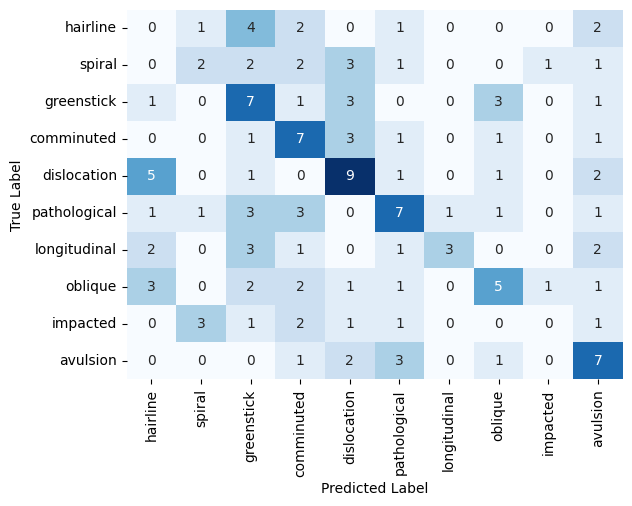

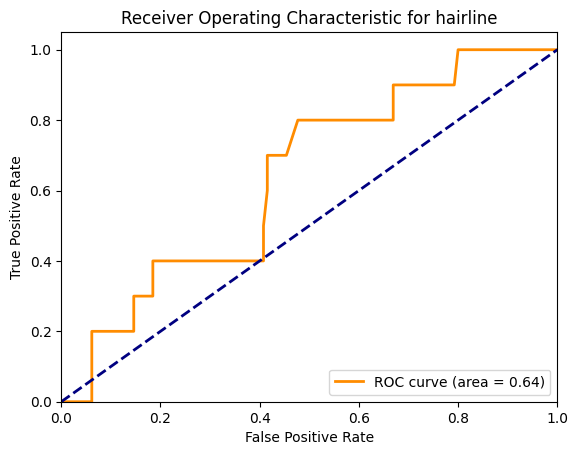

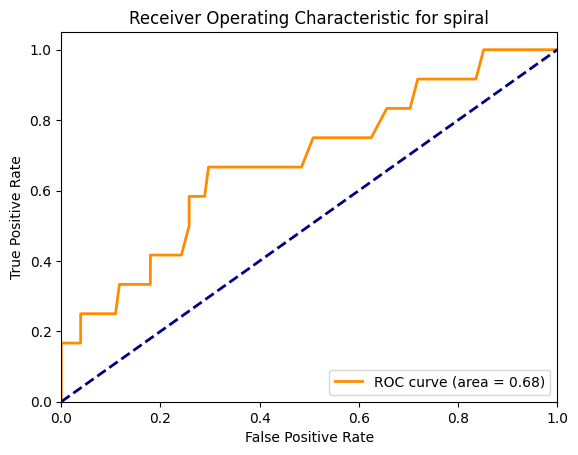

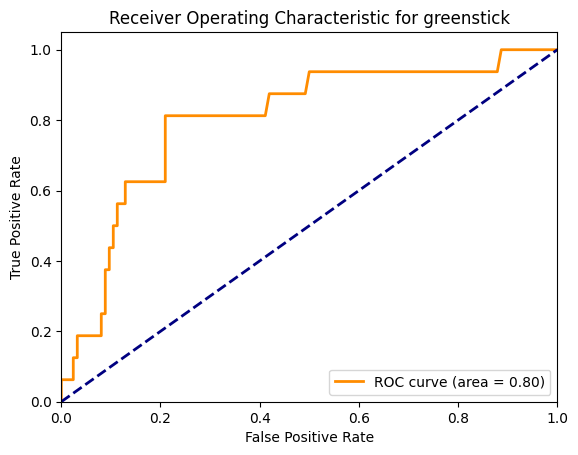

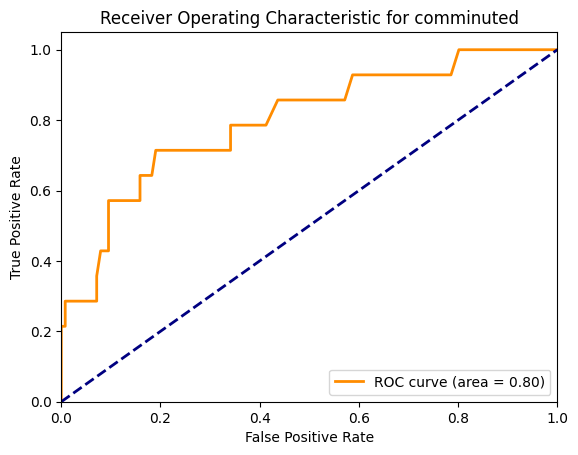

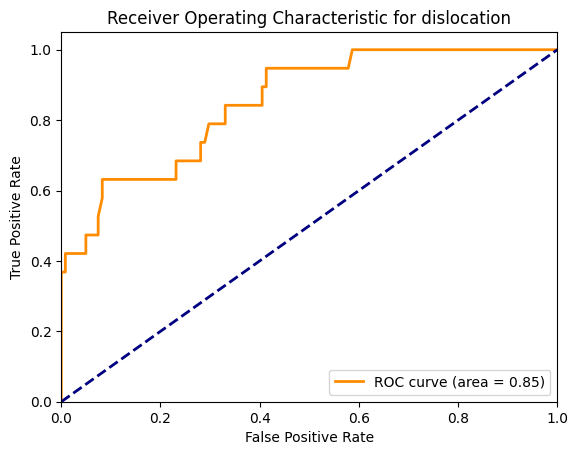

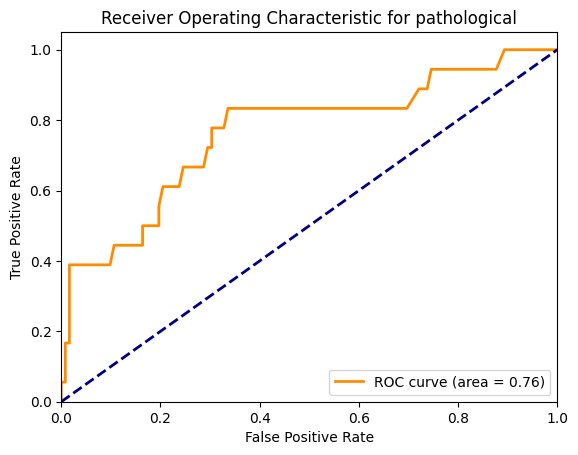

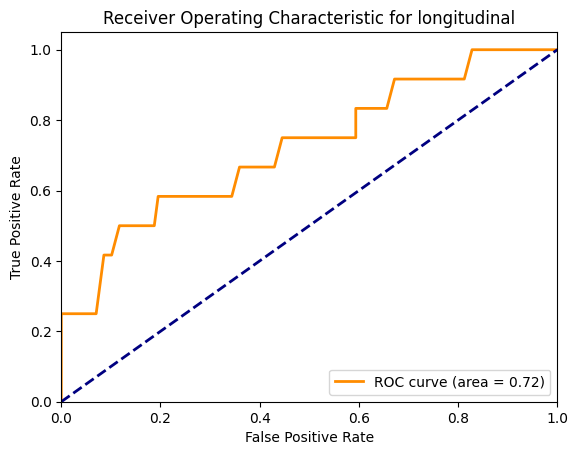

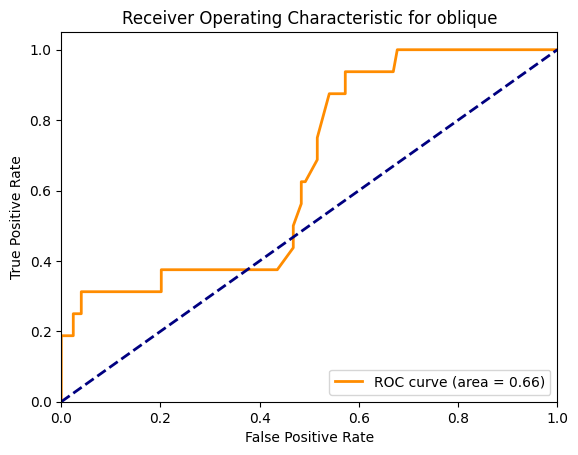

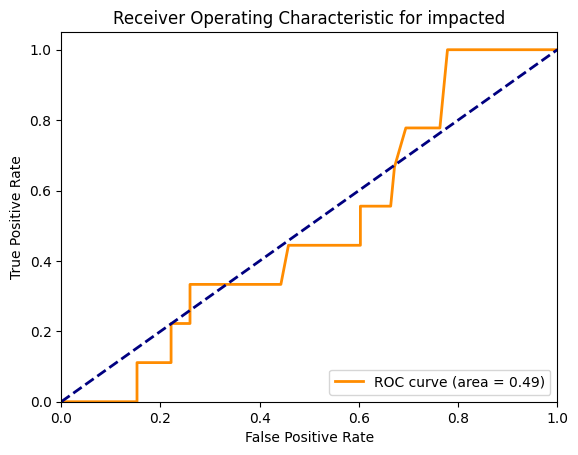

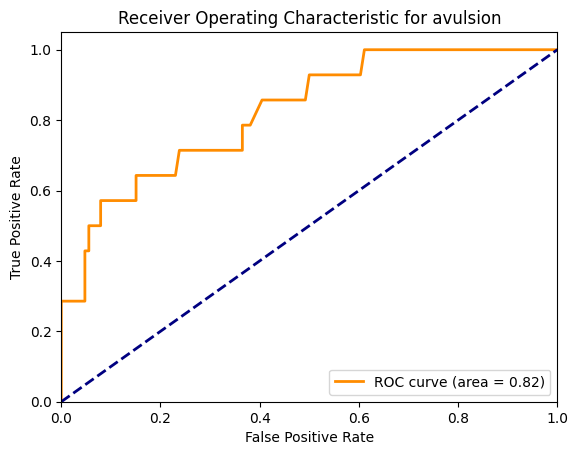

Accuracy: 0.3357142857142857
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.000000
spiral,0.285714,0.166667,0.210526,12.000000
greenstick,0.291667,0.437500,0.350000,16.000000
comminuted,0.333333,0.500000,0.400000,14.000000
dislocation,0.409091,0.473684,0.439024,19.000000
pathological,0.411765,0.388889,0.400000,18.000000
longitudinal,0.750000,0.250000,0.375000,12.000000
oblique,0.416667,0.312500,0.357143,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.368421,0.500000,0.424242,14.000000


In [7]:
y_pred = rf_1.predict(images_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = rf_1.predict_proba(images_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report


## Model 2: HOG Feature Only

In [8]:
rf_2 = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf_2.fit(hog_train, y_train)


RandomForestClassifier(n_estimators=1000, random_state=42)

/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

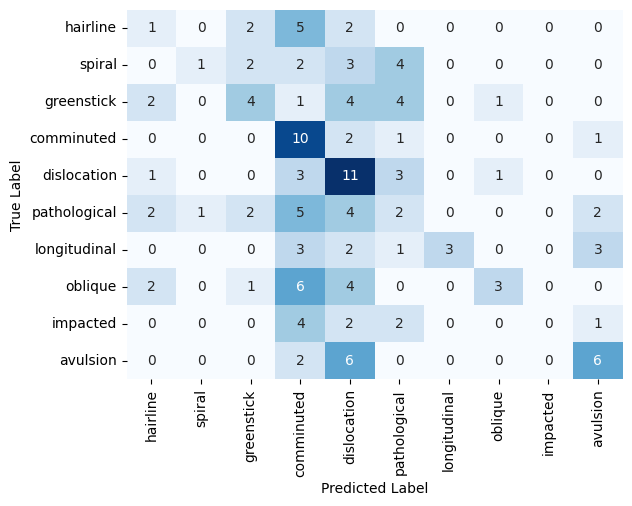

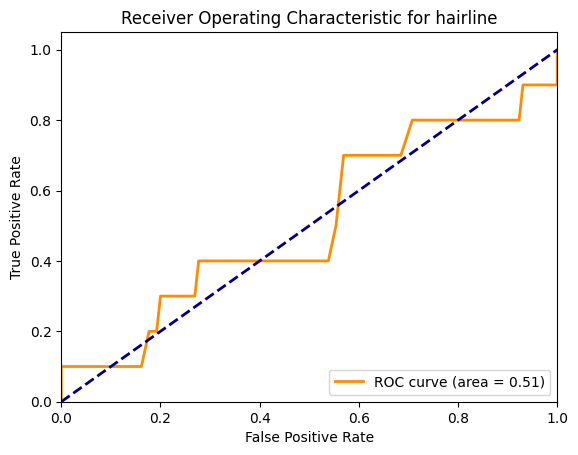

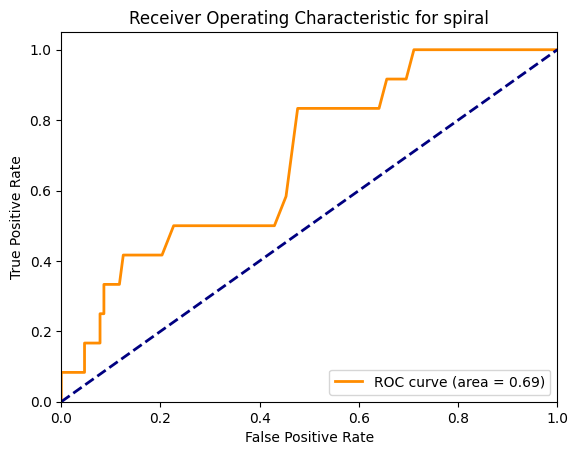

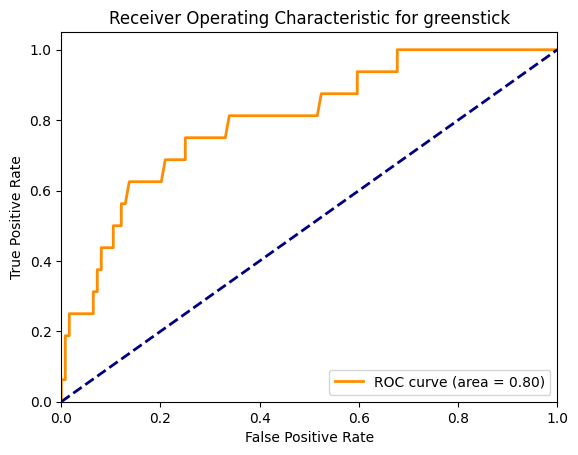

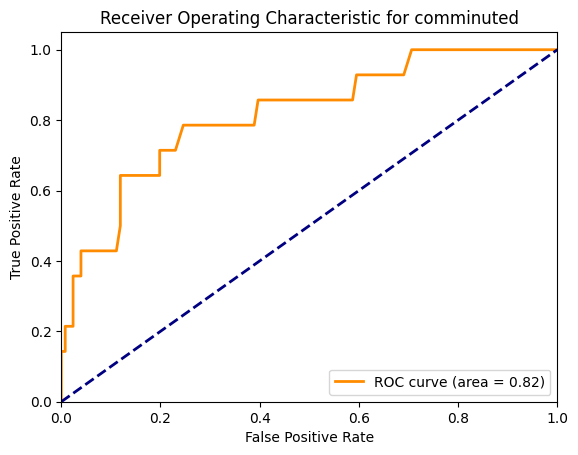

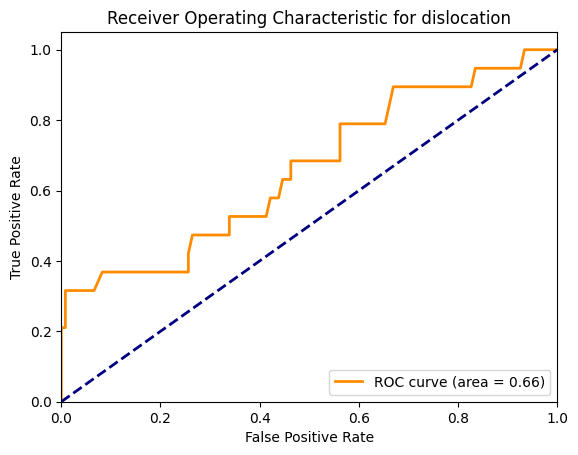

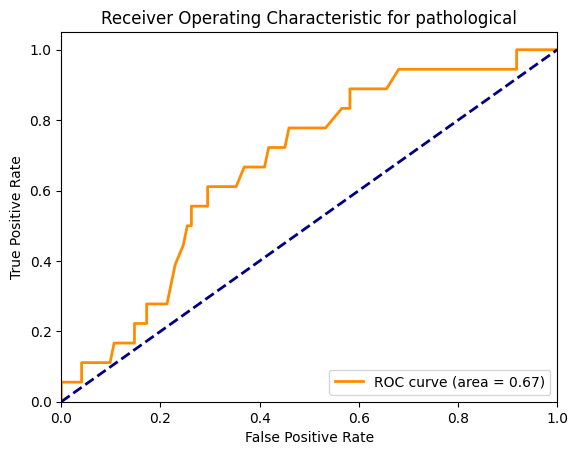

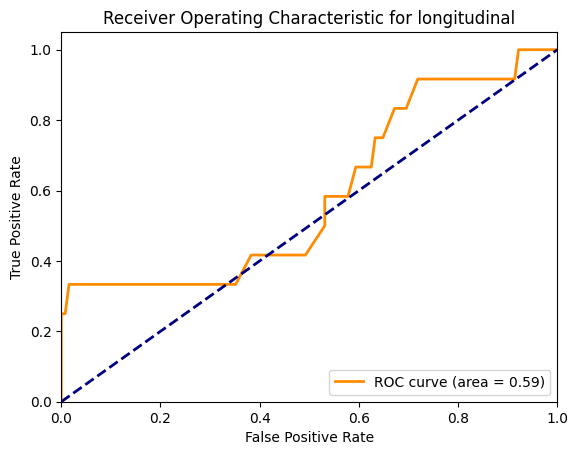

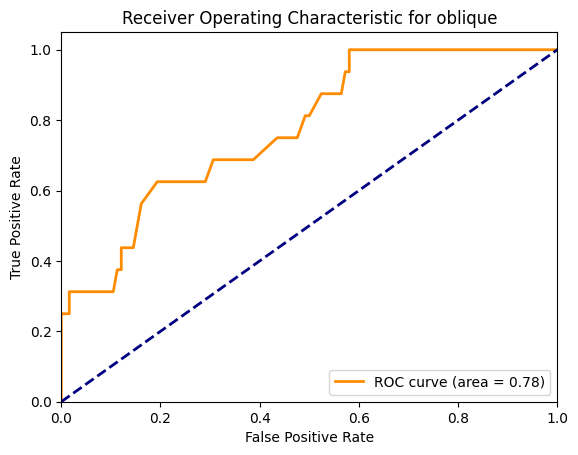

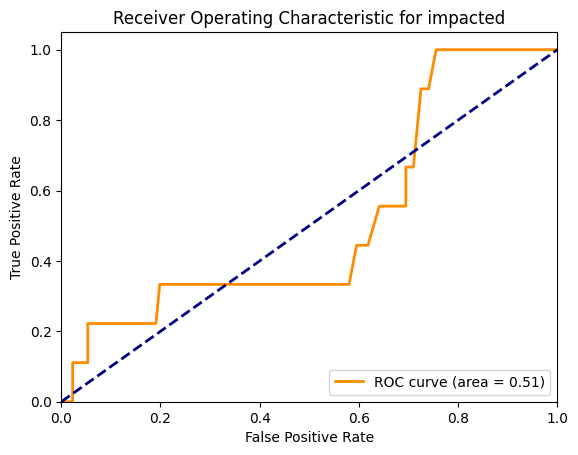

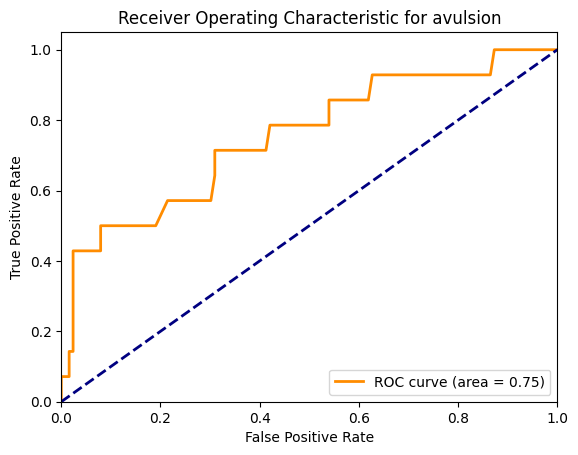

Accuracy: 0.29285714285714287
Classification Report:


,precision,recall,f1-score,support
hairline,0.125000,0.100000,0.111111,10.000000
spiral,0.500000,0.083333,0.142857,12.000000
greenstick,0.363636,0.250000,0.296296,16.000000
comminuted,0.243902,0.714286,0.363636,14.000000
dislocation,0.275000,0.578947,0.372881,19.000000
pathological,0.117647,0.111111,0.114286,18.000000
longitudinal,1.000000,0.250000,0.400000,12.000000
oblique,0.600000,0.187500,0.285714,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.461538,0.428571,0.444444,14.000000


In [9]:
y_pred = rf_2.predict(hog_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = rf_2.predict_proba(hog_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 3: Canny Edges Feature Only

In [10]:
rf_3 = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf_3.fit(canny_edges_train, y_train)


RandomForestClassifier(n_estimators=1000, random_state=42)

/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

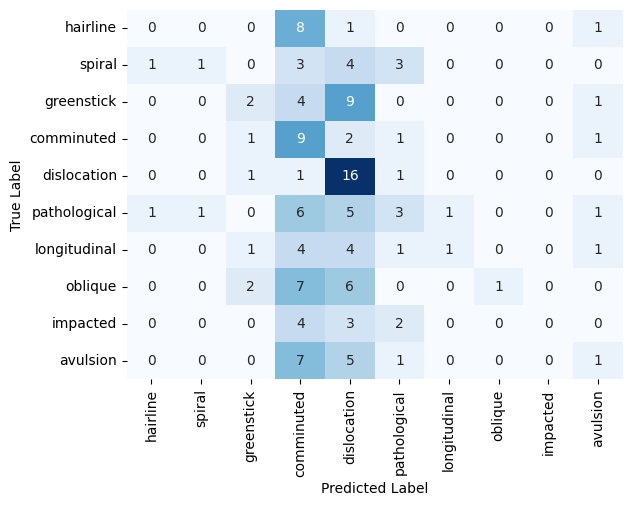

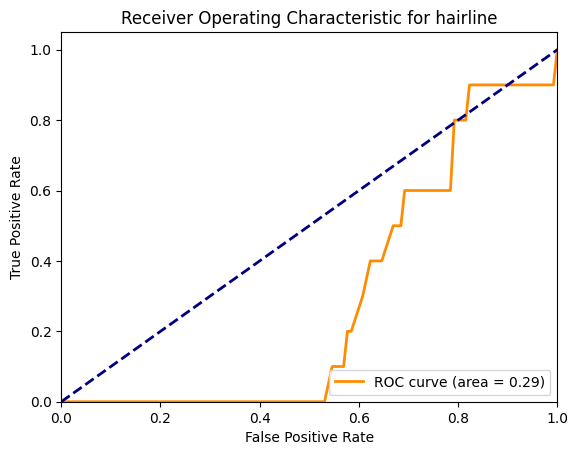

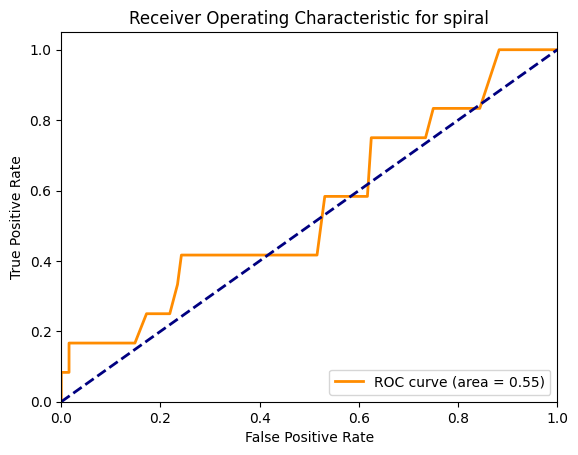

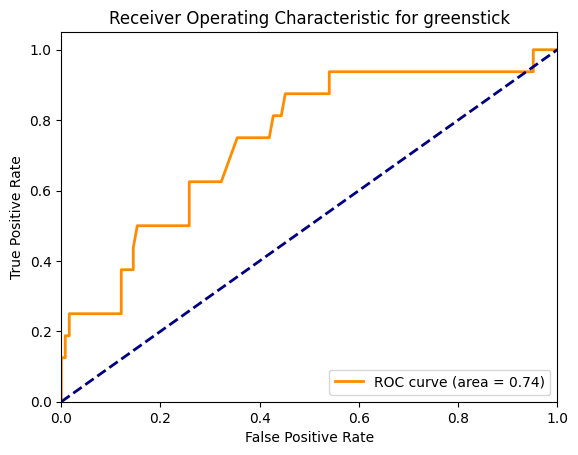

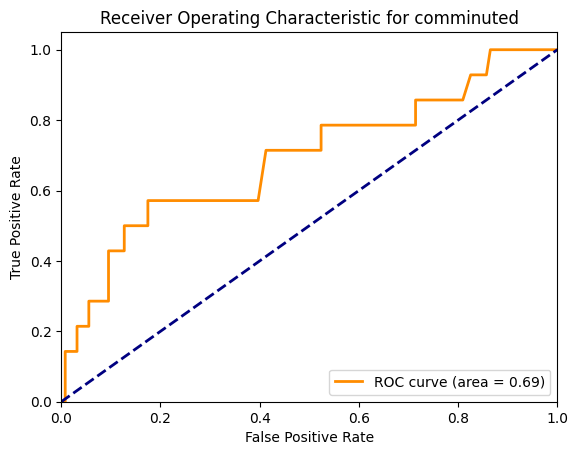

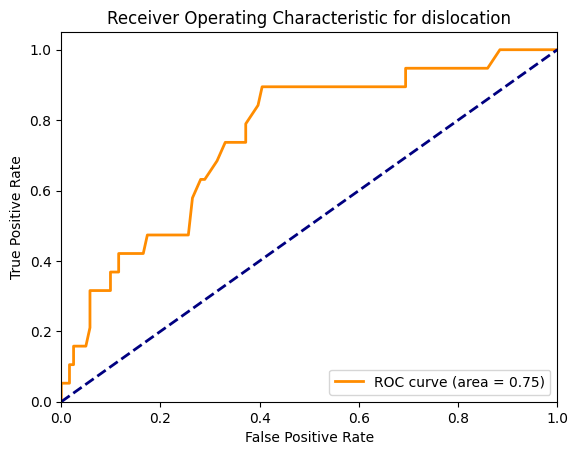

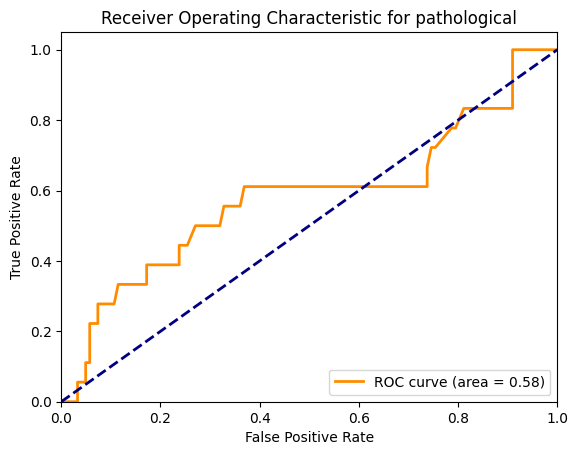

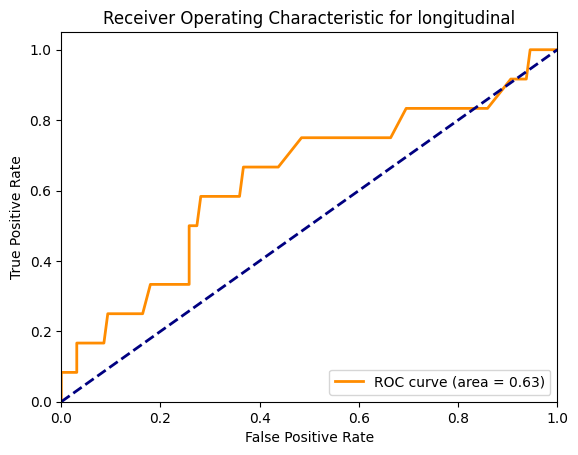

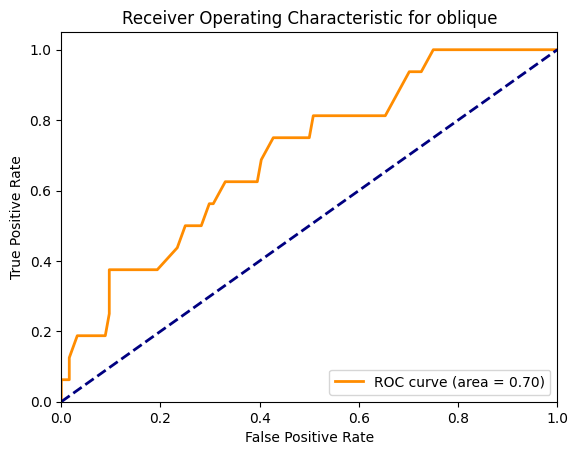

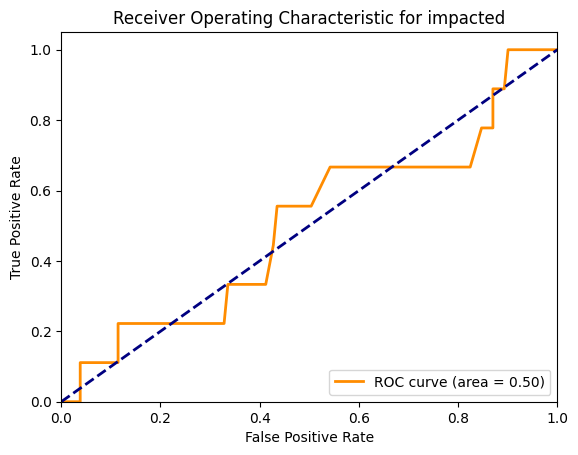

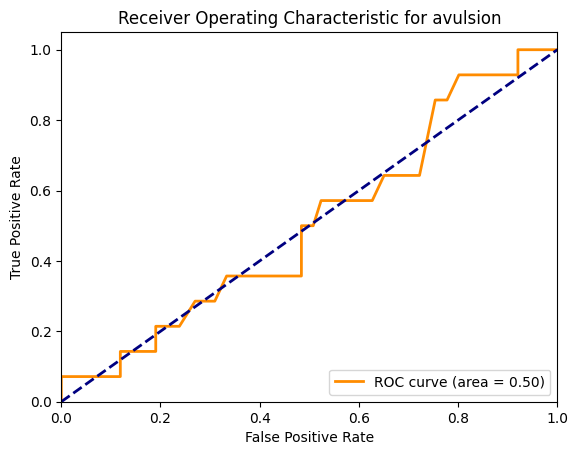

Accuracy: 0.24285714285714285
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.000000
spiral,0.500000,0.083333,0.142857,12.000000
greenstick,0.285714,0.125000,0.173913,16.000000
comminuted,0.169811,0.642857,0.268657,14.000000
dislocation,0.290909,0.842105,0.432432,19.000000
pathological,0.250000,0.166667,0.200000,18.000000
longitudinal,0.500000,0.083333,0.142857,12.000000
oblique,1.000000,0.062500,0.117647,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.166667,0.071429,0.100000,14.000000


In [11]:
y_pred = rf_3.predict(canny_edges_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = rf_3.predict_proba(canny_edges_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 4: Contours Feature Only

In [12]:
rf_4 = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf_4.fit(contours_train, y_train)


RandomForestClassifier(n_estimators=1000, random_state=42)

/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

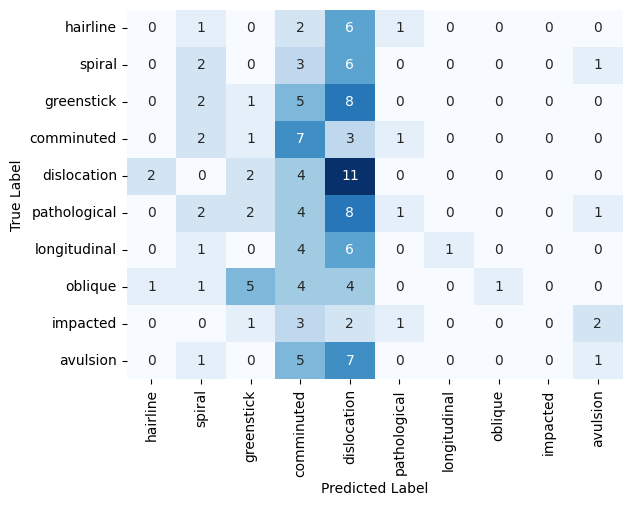

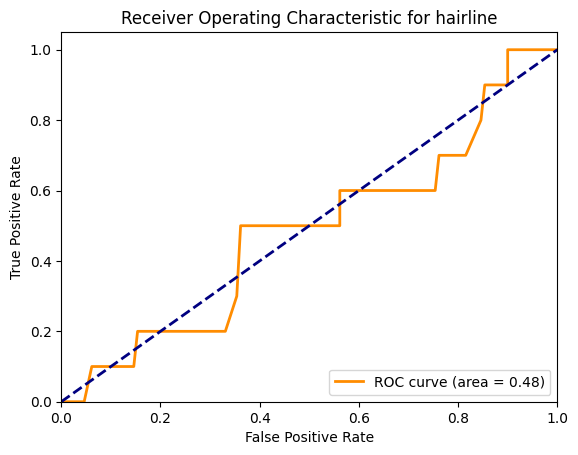

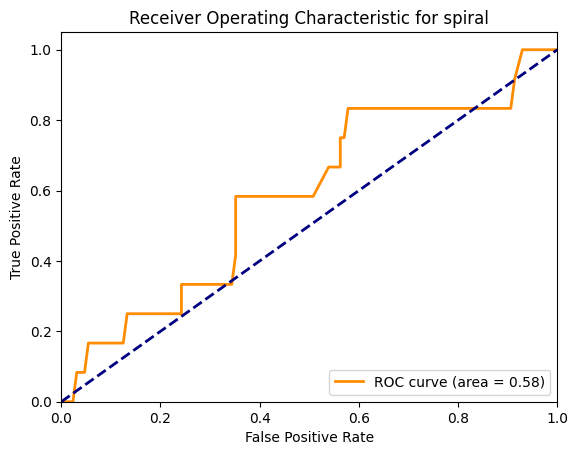

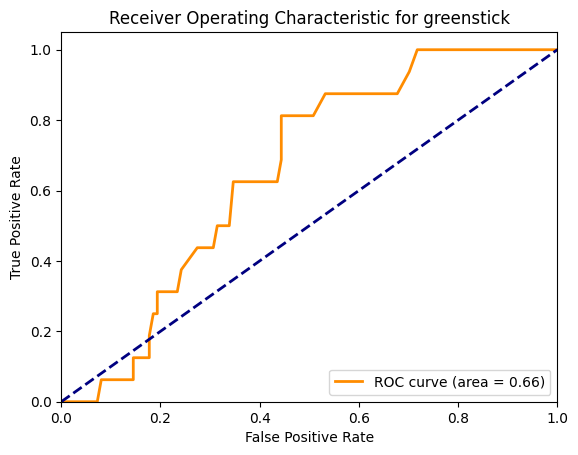

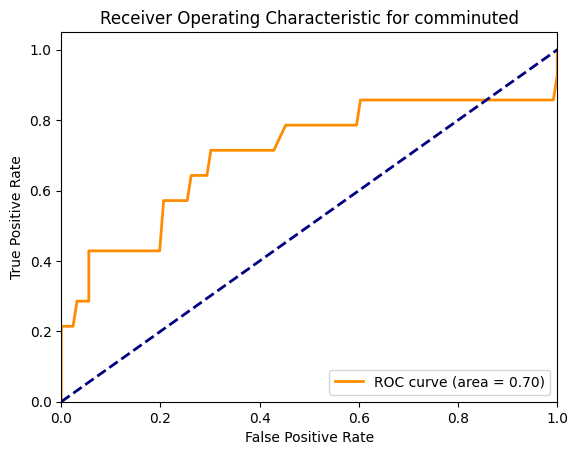

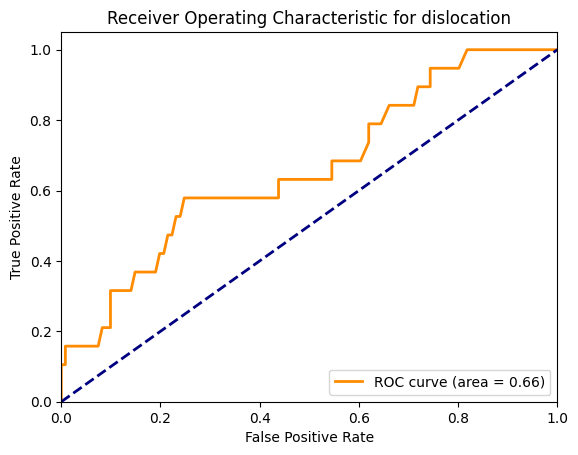

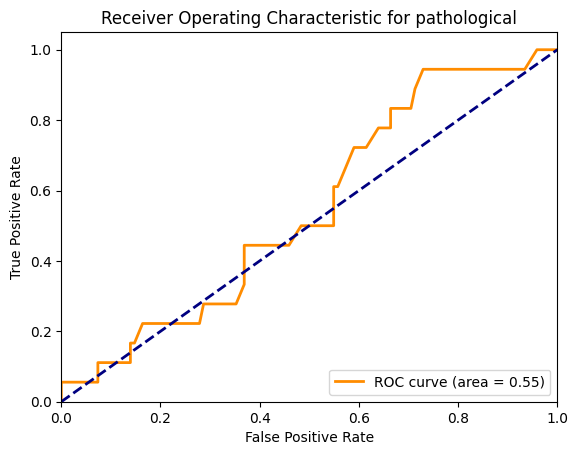

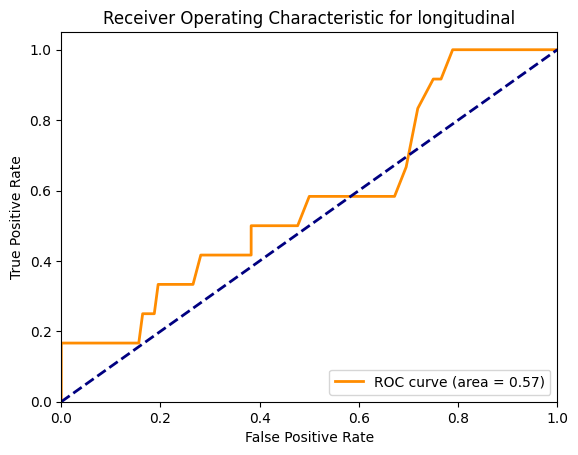

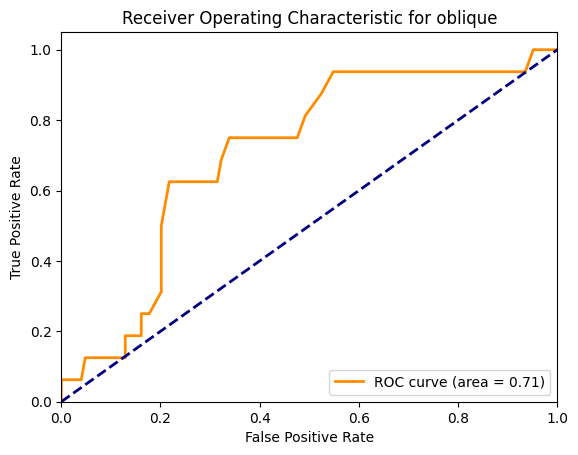

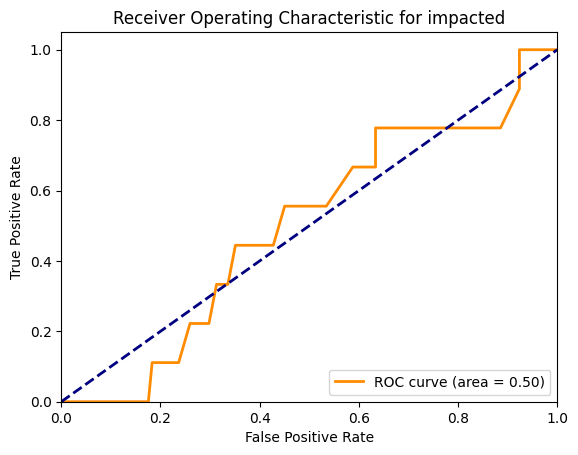

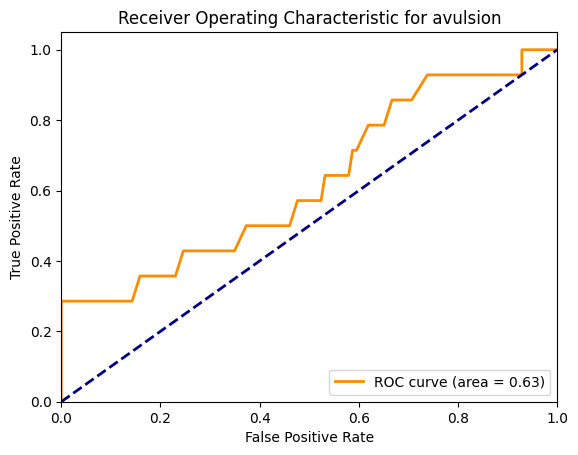

Accuracy: 0.17857142857142858
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.000000
spiral,0.166667,0.166667,0.166667,12.000000
greenstick,0.083333,0.062500,0.071429,16.000000
comminuted,0.170732,0.500000,0.254545,14.000000
dislocation,0.180328,0.578947,0.275000,19.000000
pathological,0.250000,0.055556,0.090909,18.000000
longitudinal,1.000000,0.083333,0.153846,12.000000
oblique,1.000000,0.062500,0.117647,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.200000,0.071429,0.105263,14.000000


In [13]:
y_pred = rf_4.predict(contours_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = rf_4.predict_proba(contours_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 5: VGG 19

In [14]:
rf_5 = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf_5.fit(imagenet_train, y_train)


RandomForestClassifier(n_estimators=1000, random_state=42)

In [20]:
rfc_search_space = {
    'n_estimators': [100, 1000, 10000],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rfc = RandomForestClassifier()
rand_search = RandomizedSearchCV(estimator=rfc, param_distributions=rfc_search_space, cv=3, verbose=3)
start_time = time.time()
rand_search.fit(imagenet_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END bootstrap=False, criterion=entropy, max_features=log2, n_estimators=1000;, score=0.342 total time=  12.6s
[CV 2/3] END bootstrap=False, criterion=entropy, max_features=log2, n_estimators=1000;, score=0.358 total time=  12.4s
[CV 3/3] END bootstrap=False, criterion=entropy, max_features=log2, n_estimators=1000;, score=0.362 total time=  12.1s
[CV 1/3] END bootstrap=True, criterion=entropy, max_features=sqrt, n_estimators=100;, score=0.285 total time=   8.5s
[CV 2/3] END bootstrap=True, criterion=entropy, max_features=sqrt, n_estimators=100;, score=0.321 total time=   8.8s
[CV 3/3] END bootstrap=True, criterion=entropy, max_features=sqrt, n_estimators=100;, score=0.310 total time=   8.5s
[CV 1/3] END bootstrap=False, criterion=gini, max_features=log2, n_estimators=1000;, score=0.364 total time=  12.8s
[CV 2/3] END bootstrap=False, criterion=gini, max_features=log2, n_estimators=1000;, score=0.355 total time=  12.9s

In [ ]:
model = rand_search.best_estimator_
start_time = time.time()
y_pred = model.predict(imagenet_test)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

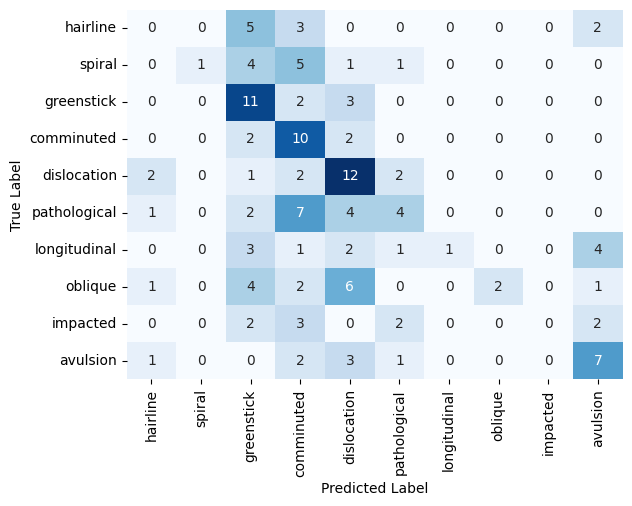

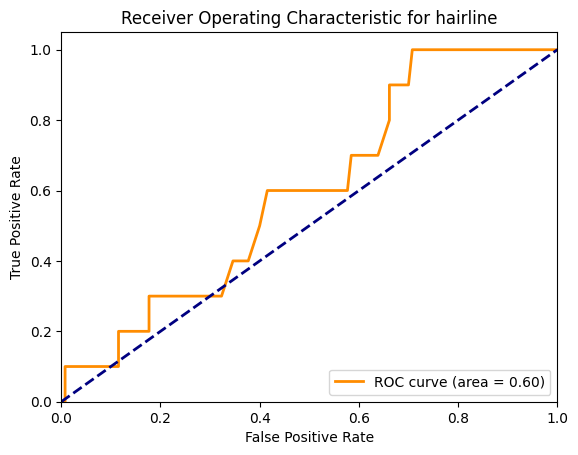

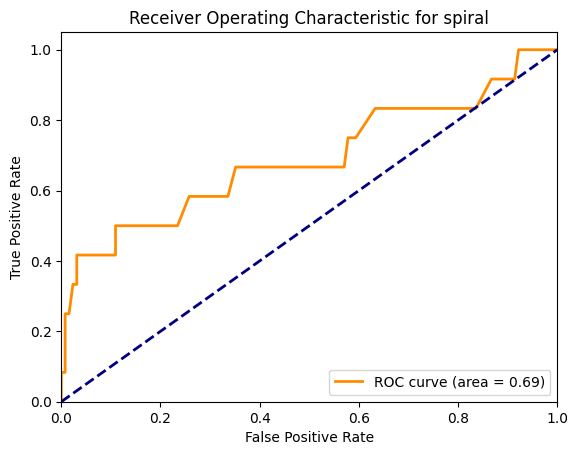

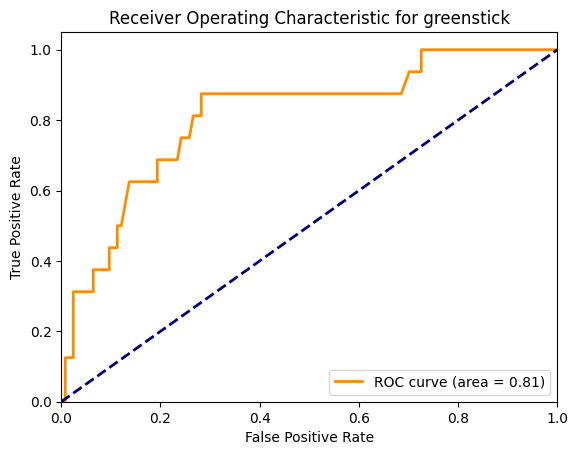

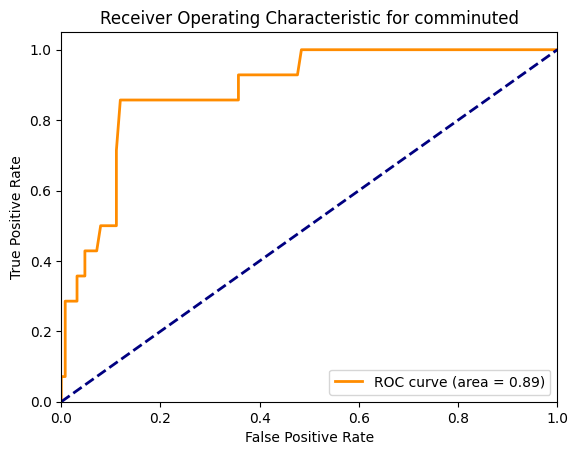

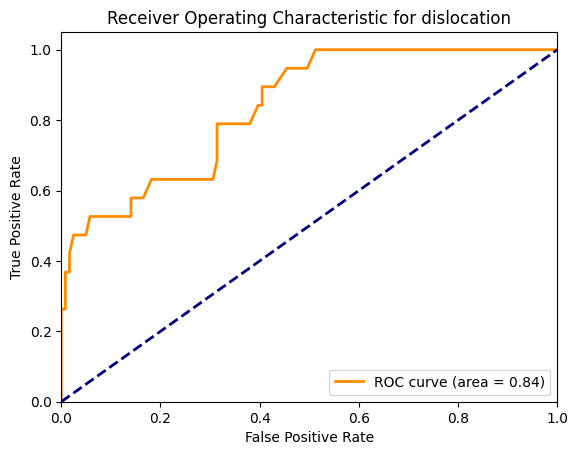

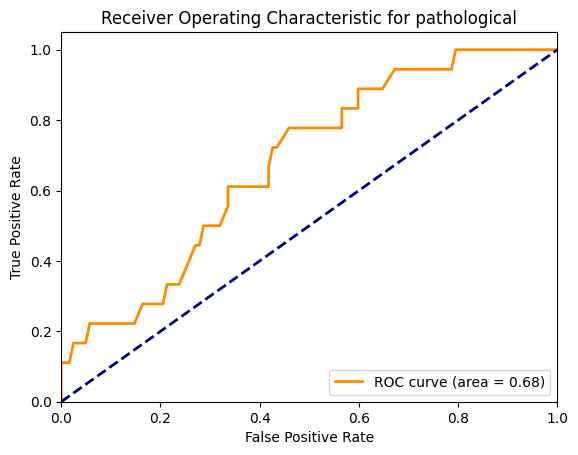

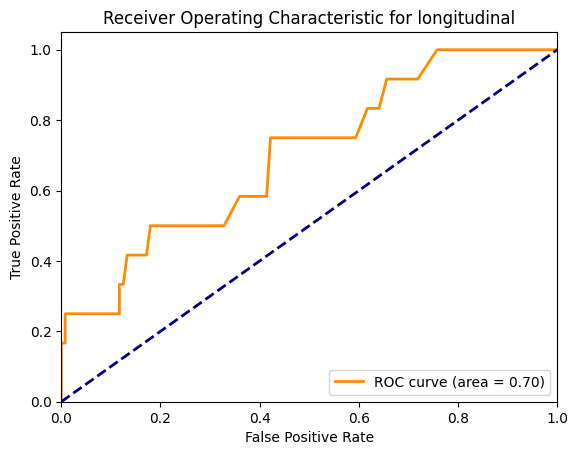

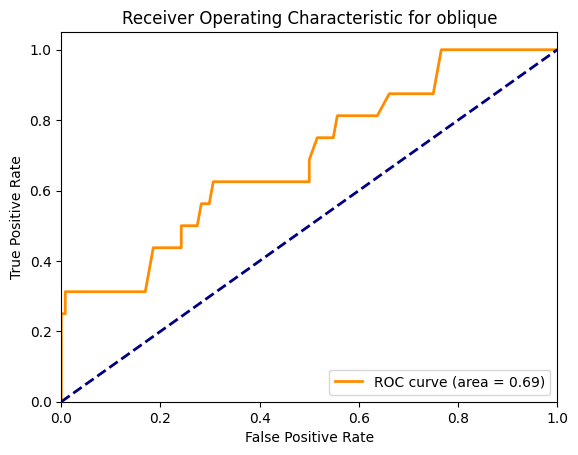

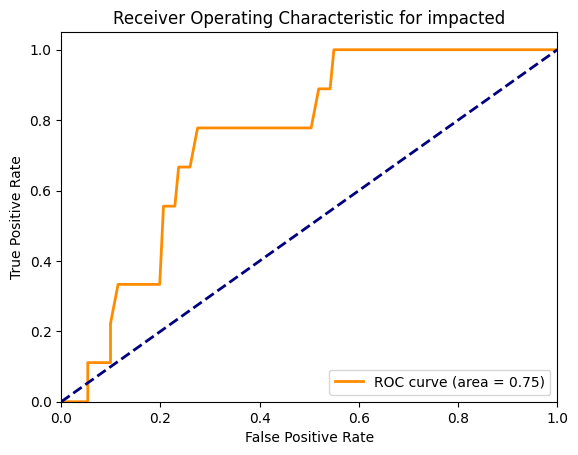

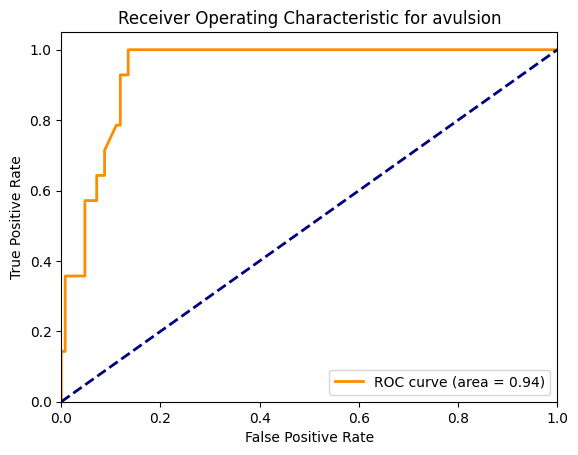

Accuracy: 0.34285714285714286
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.000000
spiral,1.000000,0.083333,0.153846,12.000000
greenstick,0.323529,0.687500,0.440000,16.000000
comminuted,0.270270,0.714286,0.392157,14.000000
dislocation,0.363636,0.631579,0.461538,19.000000
pathological,0.363636,0.222222,0.275862,18.000000
longitudinal,1.000000,0.083333,0.153846,12.000000
oblique,1.000000,0.125000,0.222222,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.437500,0.500000,0.466667,14.000000


In [15]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = rf_5.predict_proba(imagenet_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 6: PCA

In [16]:
rf_5 = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf_5.fit(pca_train, y_train)


RandomForestClassifier(n_estimators=1000, random_state=42)

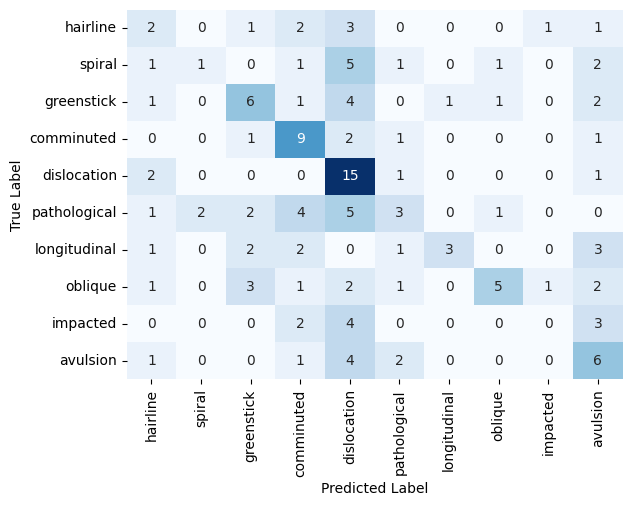

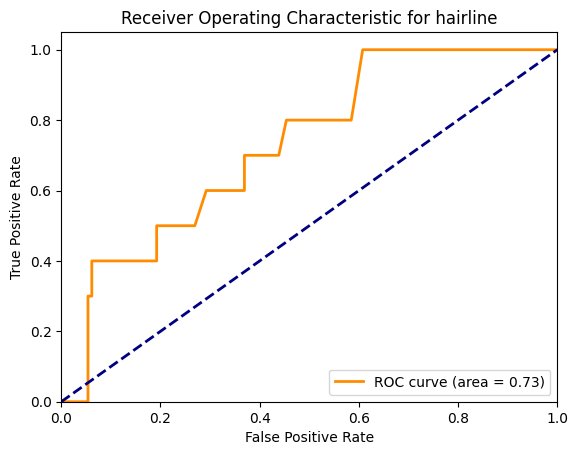

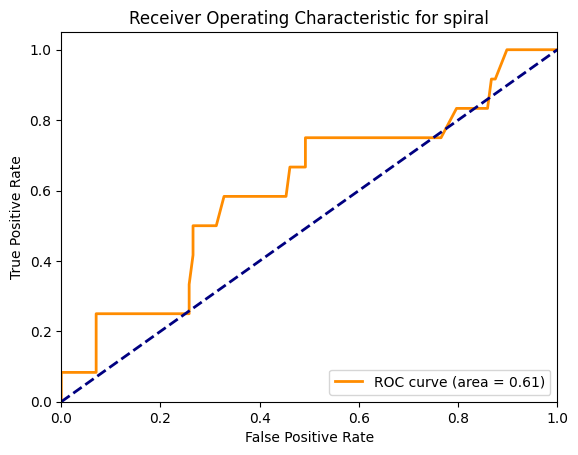

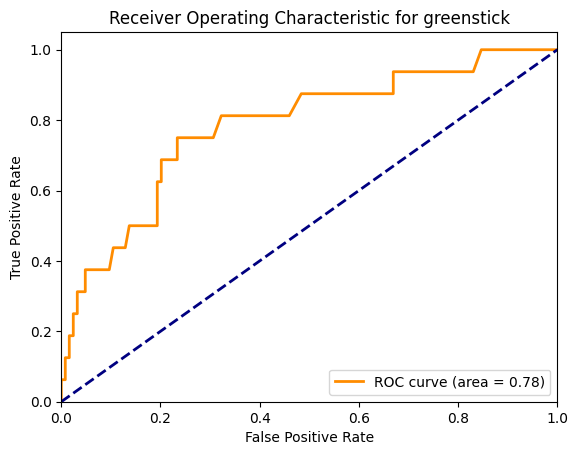

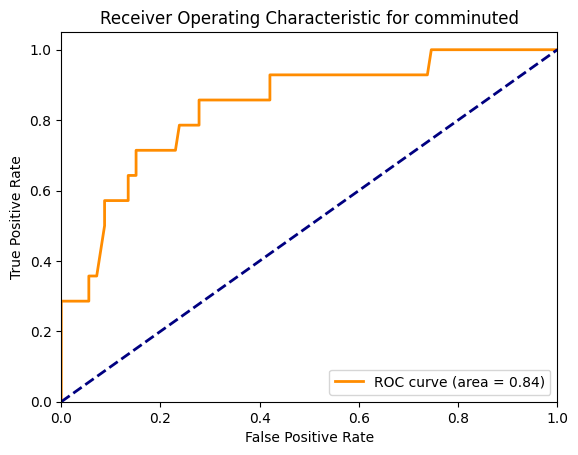

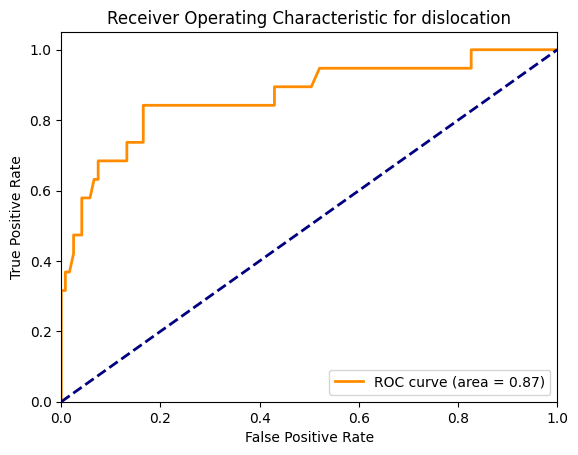

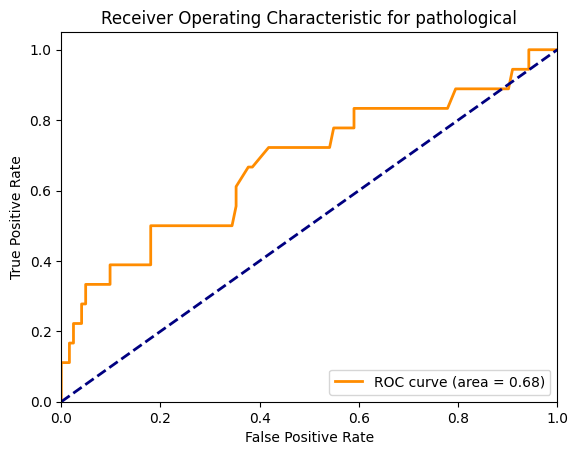

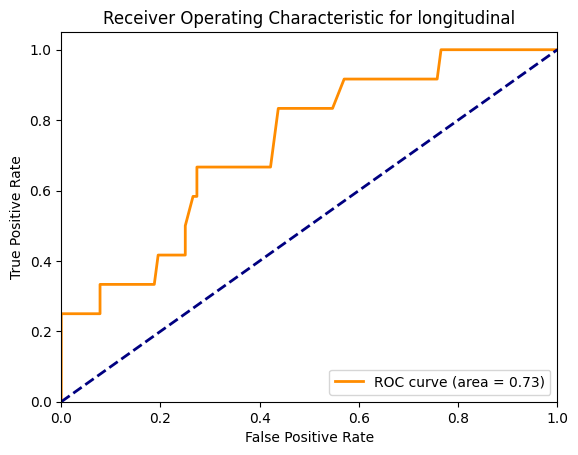

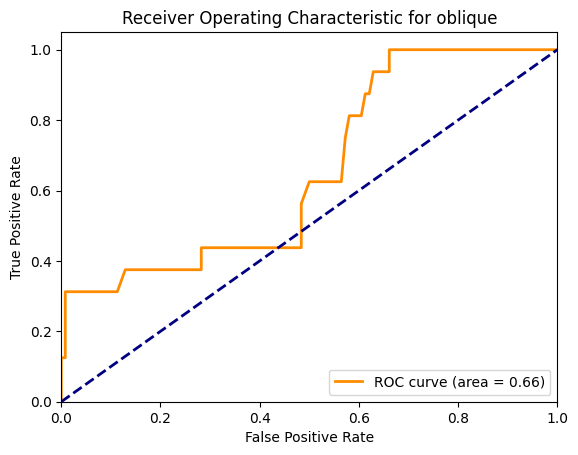

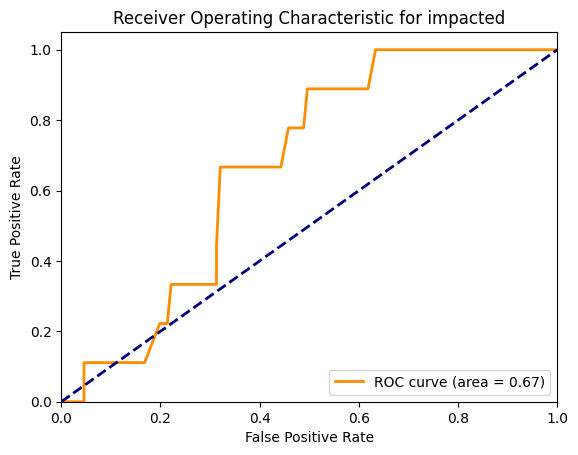

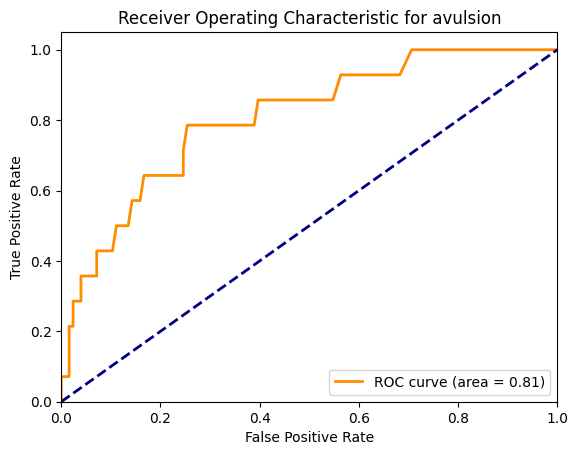

Accuracy: 0.35714285714285715
Classification Report:


,precision,recall,f1-score,support
hairline,0.200000,0.200000,0.200000,10.000000
spiral,0.333333,0.083333,0.133333,12.000000
greenstick,0.400000,0.375000,0.387097,16.000000
comminuted,0.391304,0.642857,0.486486,14.000000
dislocation,0.340909,0.789474,0.476190,19.000000
pathological,0.300000,0.166667,0.214286,18.000000
longitudinal,0.750000,0.250000,0.375000,12.000000
oblique,0.625000,0.312500,0.416667,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.285714,0.428571,0.342857,14.000000


In [17]:
y_pred = rf_5.predict(pca_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = rf_5.predict_proba(pca_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 7: Best Combination

In [18]:
X_train = np.hstack((hog_train, imagenet_train))
X_test = np.hstack((hog_test, imagenet_test))


In [19]:
rfc_search_space = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rfc = RandomForestClassifier()
rand_search = RandomizedSearchCV(estimator=rfc, param_distributions=rfc_search_space, cv=3, verbose=3)
start_time = time.time()
rand_search.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")

/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END bootstrap=True, criterion=gini, max_features=sqrt;, score=0.312 total time=   9.3s
[CV 2/3] END bootstrap=True, criterion=gini, max_features=sqrt;, score=0.315 total time=   9.3s
[CV 3/3] END bootstrap=True, criterion=gini, max_features=sqrt;, score=0.295 total time=   9.4s
[CV 1/3] END bootstrap=True, criterion=gini, max_features=log2;, score=0.270 total time=   0.9s
[CV 2/3] END bootstrap=True, criterion=gini, max_features=log2;, score=0.318 total time=   0.9s
[CV 3/3] END bootstrap=True, criterion=gini, max_features=log2;, score=0.316 total time=   0.9s
[CV 1/3] END bootstrap=True, criterion=entropy, max_features=sqrt;, score=0.242 total time=   6.8s
[CV 2/3] END bootstrap=True, criterion=entropy, max_features=sqrt;, score=0.309 total time=   6.8s
[CV 3/3] END bootstrap=True, criterion=entropy, max_features=sqrt;, score=0.298 total time=   6.8s
[CV 1/3] END bootstrap=True, criterion=entropy, max_features=log2;,

In [20]:
model = rand_search.best_estimator_
start_time = time.time()
y_pred = model.predict(X_test)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

Inference time: 0.05 seconds


/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

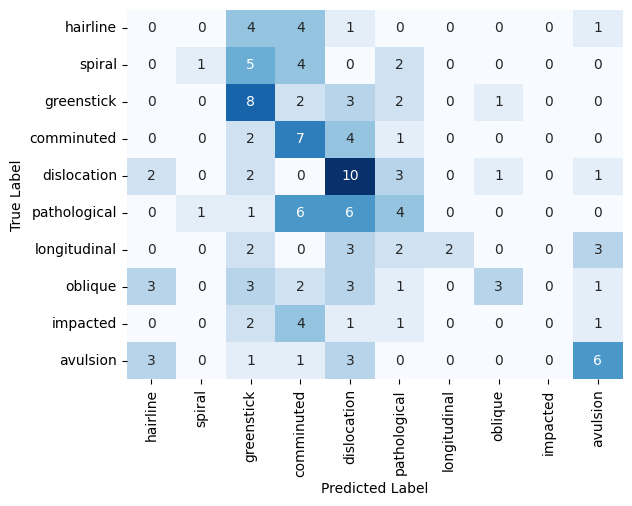

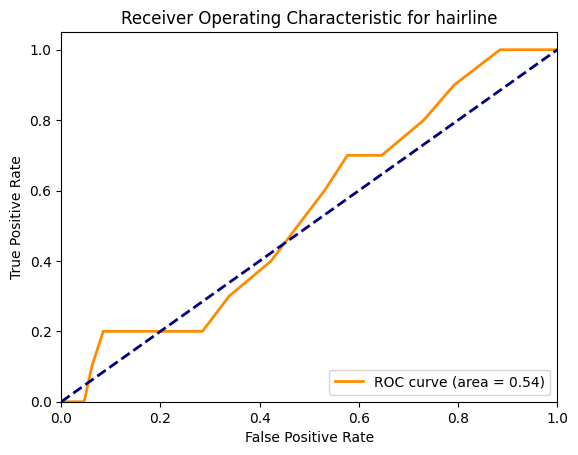

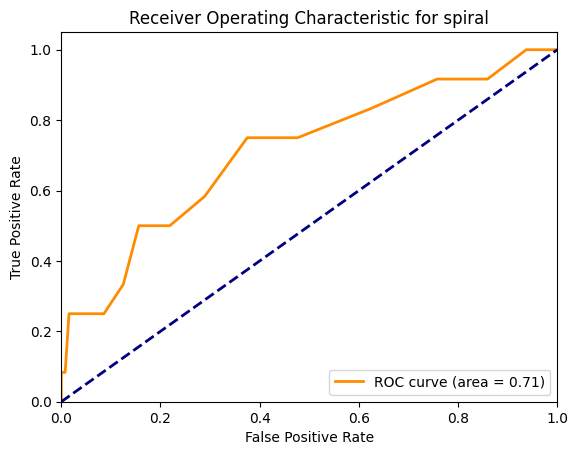

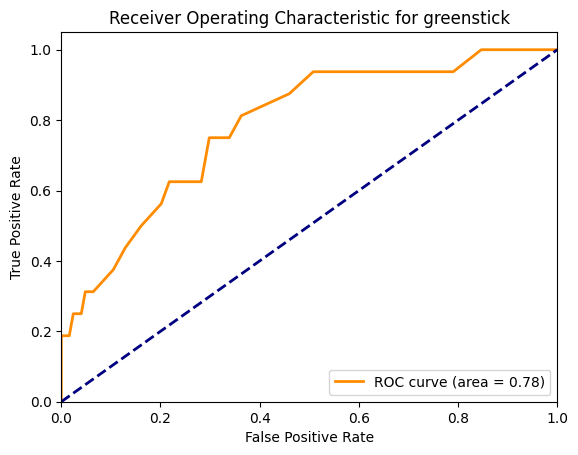

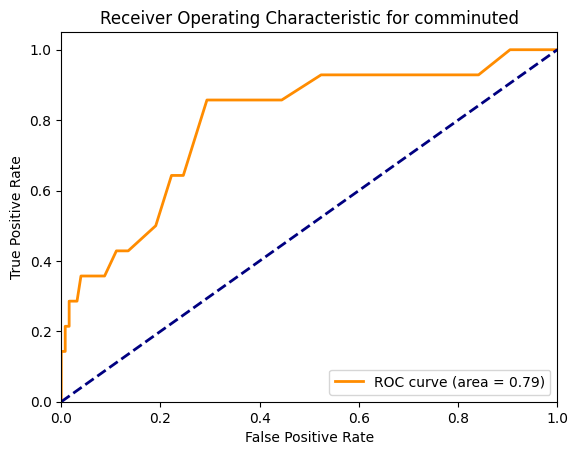

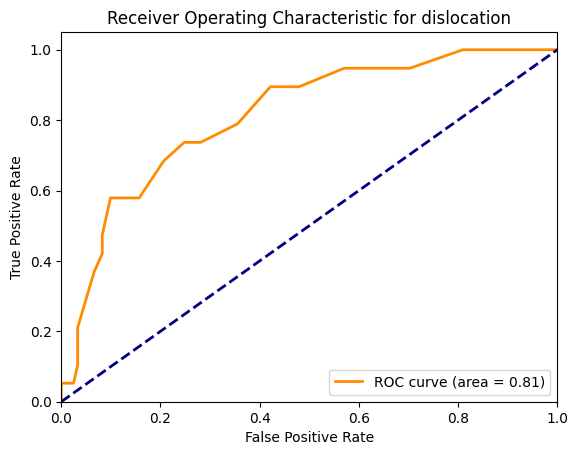

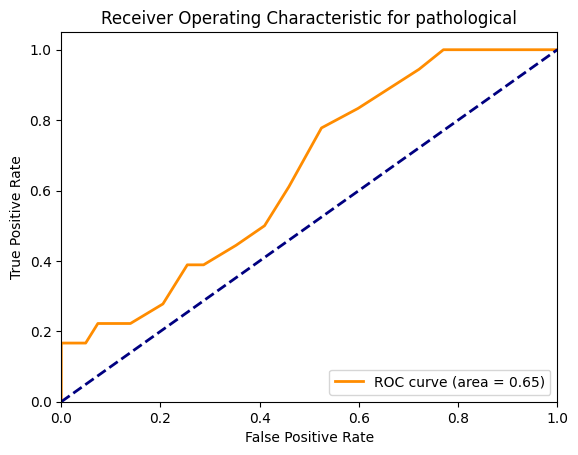

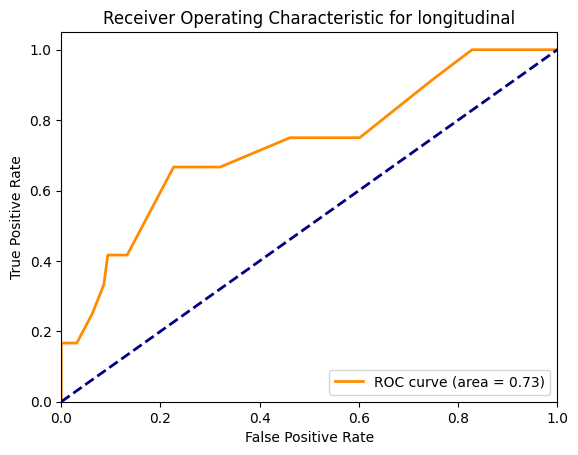

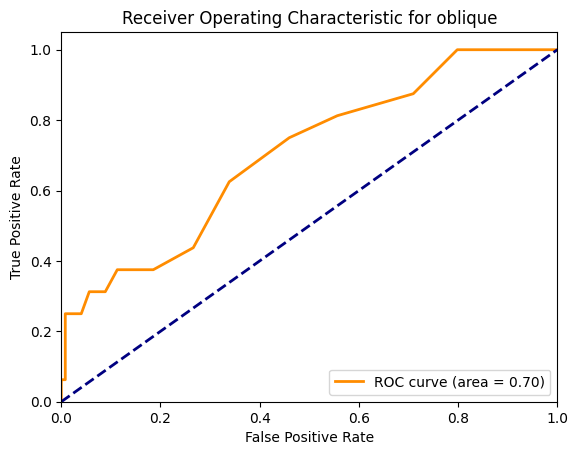

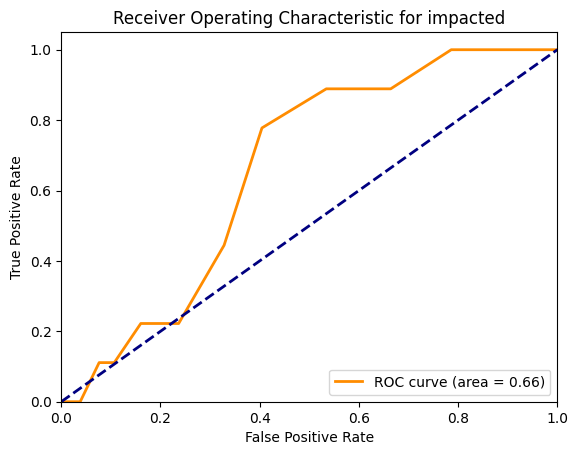

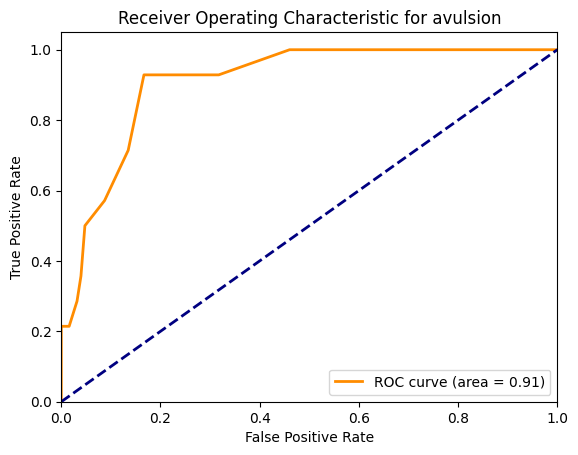

Accuracy: 0.29285714285714287
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.000000
spiral,0.500000,0.083333,0.142857,12.000000
greenstick,0.266667,0.500000,0.347826,16.000000
comminuted,0.233333,0.500000,0.318182,14.000000
dislocation,0.294118,0.526316,0.377358,19.000000
pathological,0.250000,0.222222,0.235294,18.000000
longitudinal,1.000000,0.166667,0.285714,12.000000
oblique,0.600000,0.187500,0.285714,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.461538,0.428571,0.444444,14.000000


In [21]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(X_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report